#### NX-414: Brain-like computation and intelligence
##### TA: Alessandro Marin Vargas

# Week 7 - Mini projects (Predicting neural activity)

The objectives of the mini project are:
- Learn how to predict neural activity using linear regression from images and from neural network layers.
- Quantify the goodness of the model
- Compare the results across the network layers and between trained/random neural network
- Predict the neural activity using a neural network in a data-driven approach

Specifically, here you will use the data from the following [paper](https://www.jneurosci.org/content/jneuro/35/39/13402.full.pdf). The behavioral experiment consisted in showing to non-human primates some images while recording the neural activity with multielectrode arrays from the inferior temporal (IT) cortex. Here, the neural activity and the images are already pre-processed and you will have available the images and the corresponding average firing rate (between 70 and 170 ms) per each neuron.

In [1]:
import sys
sys.path.append('./../')
!{sys.executable} -m pip install gdown h5py

In [2]:
from utils import load_it_data
import gdown
url = "https://drive.google.com/file/d/1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS/view?usp=share_link"
output = "IT_data.h5"
gdown.download(url, output, quiet=False, fuzzy=True)


Downloading...
From (uriginal): https://drive.google.com/uc?id=1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS
From (redirected): https://drive.google.com/uc?id=1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS&confirm=t&uuid=25be0480-25a0-46ab-915d-4a4ab3cd4011
To: /home/jupyter/IT_data.h5
100%|██████████| 384M/384M [00:14<00:00, 26.1MB/s] 


'IT_data.h5'

### Load the data

In [3]:
path_to_data = '' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)
layers = ["conv1", "layer1", "layer2", "layer3", "layer4", "avgpool"]

# Challenge: Develop the most accurate model for predicting IT neural activity.

Throughout the mini-projects, you have acquired knowledge on predicting neural activity through both task-driven and data-driven approaches. You are now free to explore both approaches to create the most effective model for predicting neural activity. Here are some suggestions to help guide your exploration:
- Optimize your current models by adjusting hyperparameters and implementing different regularizations.
- Utilize different pretrained models.
- Employ a pretrained neural network and finetune it for predicting the neural activity.
- Train a neural network for object recognition while simultaneously predicting neural activity.
- ...

Please note that all models will be tested using the same type of linear regression.

### EVALUATION

You have until midnight of 19/04/23 to submit your mini-projects. Please upload a .zip file on Moodle containing your code and, specifically, the following:

- A one-page report (Report.pdf) detailing your investigation, including figures and model comparisons.
- A script (test.py) or notebook (test.ipynb) in which you show an example of your best model's usage. Please include instructions on loading the model and making neural predictions on the validation set. If necessary, include the checkpoint of your model in the .zip file.

Best of luck!

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import explained_variance_score, r2_score
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import ResNet, resnet50, ResNet50_Weights
from torch.utils.data import TensorDataset, DataLoader
import pickle
from tqdm import tqdm
import copy

# Fine-tune ResNet50 for classification of the images

In [5]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    val_acc_history = []
    model = model.cuda()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            # Initialize the losses for this epoch
            loss = 0.0
            corrects = 0
            
            steps_per_epoch_train = len(dataloaders['train'])
            steps_per_epoch_val = len(dataloaders['val'])
            
            for stimulus, label in dataloaders[phase]:
                stimulus, label = stimulus.cuda(), label.cuda()

                # zero out the parameter gradients
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    # Forward pass (compute training loss)
                    prediction = model(stimulus)
                    loss = criterion(prediction, label)
                    
                    _, preds = torch.max(prediction, 1)

                    # Backward pass (compute new gradients, update weights))
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Update the loss for this epoch
                loss += loss.item() * stimulus.size(0)
                corrects += torch.sum(preds == label.data)

            epoch_loss = loss / len(dataloaders[phase].dataset)
            epoch_acc = corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()
    
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [6]:
# Parameters
num_classes = len(np.unique(objects_train))
BATCH_SIZE = 10
EPOCHS = 50
LR = 0.001 

feature_extract = False # to finetune the model

# Datasets and dataloaders
le = preprocessing.LabelEncoder()

dataset_train = TensorDataset(torch.tensor(stimulus_train), torch.tensor(le.fit_transform(objects_train)))
dataset_val = TensorDataset(torch.tensor(stimulus_val), torch.tensor(le.fit_transform(objects_val)))
dataset_test = TensorDataset(torch.tensor(stimulus_test))
dataloaders = {'train' : DataLoader(dataset_train, shuffle=True, batch_size=BATCH_SIZE), 
               'val' : DataLoader(dataset_val, batch_size=BATCH_SIZE)}
testDataLoader = DataLoader(dataset_test, batch_size=BATCH_SIZE)

In [7]:
# Initialize and reshape the model
model = resnet50(weights=ResNet50_Weights.DEFAULT)
#model.fc = nn.Linear(512, num_classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)
params_to_update = model.parameters()

# Create the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params_to_update, lr=LR, momentum=0.9)

In [8]:
# Fine-tune the model
model, _ = train_model(model, dataloaders, criterion, optimizer, num_epochs=EPOCHS)

Epoch 0/49
----------
train Loss: 0.0040 Acc: 0.1073
val Loss: 0.1024 Acc: 0.3646

Epoch 1/49
----------
train Loss: 0.0045 Acc: 0.5135
val Loss: 0.0258 Acc: 0.7326

Epoch 2/49
----------
train Loss: 0.0018 Acc: 0.7589
val Loss: 0.0085 Acc: 0.8229

Epoch 3/49
----------
train Loss: 0.0017 Acc: 0.8603
val Loss: 0.0107 Acc: 0.8507

Epoch 4/49
----------
train Loss: 0.0018 Acc: 0.9132
val Loss: 0.0022 Acc: 0.8750

Epoch 5/49
----------
train Loss: 0.0011 Acc: 0.9352
val Loss: 0.0023 Acc: 0.8264

Epoch 6/49
----------
train Loss: 0.0017 Acc: 0.9514
val Loss: 0.0025 Acc: 0.8889

Epoch 7/49
----------
train Loss: 0.0010 Acc: 0.9668
val Loss: 0.0068 Acc: 0.8958

Epoch 8/49
----------
train Loss: 0.0010 Acc: 0.9811
val Loss: 0.0023 Acc: 0.9132

Epoch 9/49
----------
train Loss: 0.0004 Acc: 0.9892
val Loss: 0.0011 Acc: 0.9236

Epoch 10/49
----------
train Loss: 0.0008 Acc: 0.9950
val Loss: 0.0007 Acc: 0.9236

Epoch 11/49
----------
train Loss: 0.0003 Acc: 0.9973
val Loss: 0.0060 Acc: 0.9236

Ep

# Extract the activations and predict the neural activity

In [21]:
def extract_activations(self, stimuli, layer) :
    """extract the activations of the model for the given stimuli and layer

    Args:
        model (model): model we want to extract the activations from
        stimuli (ndarray): input data of the processed image's pixels

    Returns:
        dict: dictionary containing the activations for each layer of the model
    """    
    #stimuli = torch.tensor(stimuli)
    activations = []
    for x in stimuli : 
        #x = self.conv1(x.unsqueeze(0))
        x = self.conv1(x.unsqueeze(0))
        if layer == 'conv1' : 
            #activations.append(torch.flatten(x.squeeze(0)).detach().numpy())
            activations.append(torch.flatten(x.squeeze(0)).detach().cpu().numpy())
            continue
        
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        if layer == 'layer1' : 
            activations.append(torch.flatten(x.squeeze(0)).detach().cpu().numpy())
            continue
    
        x = self.layer2(x)
        if layer == 'layer2' : 
            activations.append(torch.flatten(x.squeeze(0)).detach().cpu().numpy())
            continue
        
        x = self.layer3(x)
        if layer == 'layer3' : 
            activations.append(torch.flatten(x.squeeze(0)).detach().cpu().numpy())
            continue
    
        x = self.layer4(x)
        if layer == 'layer4' :       
            activations.append(torch.flatten(x.squeeze(0)).detach().cpu().numpy())
            continue
        
        x = self.avgpool(x)
        if layer == 'avgpool' : 
            activations.append(torch.flatten(x.squeeze(0)).detach().cpu().numpy())
            continue
    return activations

ResNet.extract_activations = extract_activations

In [22]:
# extract the activations of the layers and apply PCA on each layer to store the first 1000PCs
model.eval()
for layer in tqdm(layers) : 
    #activations_train = model.extract_activations(stimulus_train, layer)
    activations_train = model.extract_activations(torch.tensor(stimulus_train).cuda(), layer) 
    pca = PCA(n_components=1000)
    pca.fit(activations_train)    
    with open(layer+'_train_W8.pkl','wb') as f:
        pickle.dump(pca.transform(activations_train), f)
    with open(layer+'_val_W8.pkl','wb') as f:
        #pickle.dump(pca.transform(model.extract_activations(stimulus_val, layer)), f)
        pickle.dump(pca.transform(model.extract_activations(torch.tensor(stimulus_val).cuda(), layer)), f)
    with open(layer+'_test_W8.pkl','wb') as f:
        #pickle.dump(pca.transform(model.extract_activations(stimulus_test, layer)), f)
        pickle.dump(pca.transform(model.extract_activations(torch.tensor(stimulus_test).cuda(), layer)), f)

100%|██████████| 6/6 [18:37<00:00, 186.29s/it]


In [23]:
def best_alpha_Ridge(X, y, alphas):
    """implement cross validation to find the best alpha for Ridge regression

    Args:
        X (ndarray): input data
        y (ndarray): output data, neuronal activity
        alphas (list of double): list of alpha to test

    Returns:
        tuple (double, ndarray): best alpha and all the scores for each alpha
    """
    scores = []
    for alpha in alphas:
        model = Ridge(alpha=alpha)
        cv_scores = cross_val_score(model, X, y, cv=5)
        scores.append(np.mean(cv_scores))
    return alphas[np.argmax(scores)], scores

def plot_RidgeCV(alphas, scores):
    """plot the scores for each alpha

    Args:
        alphas (list of double): list of alpha that were tested
        scores (list of double): list of scores for each alpha
    """
    plt.figure(figsize=(3,2))
    plt.plot(alphas, scores)
    plt.xlabel('alpha')
    plt.ylabel('r2 score')
    plt.show()
    
def RidgeCV(X, y, alphas):
    """find the best alpha for Ridge regression and plot the scores for each alpha, then fit the model with the best alpha

    Args:
        X (ndarray): input data
        y (ndarray): output data, neuronal activity
        alphas (list of double): list of alpha to test

    Returns:
        tuple (model, double): the ridge model fitted with the best alpha and the corresponding alpha
    """
    best_alpha, scores = best_alpha_Ridge(X, y, alphas)
    plot_RidgeCV(alphas, scores)
    print('The best alpha is', best_alpha)
    model = Ridge(alpha=best_alpha)
    model.fit(X, y)
    return model, best_alpha



R2 score for conv1 in function of the parameter alpha : 


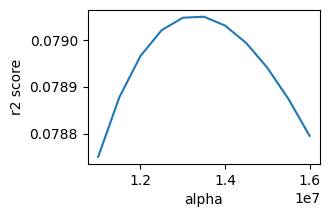

The best alpha is 13500000


R2 score for layer1 in function of the parameter alpha : 


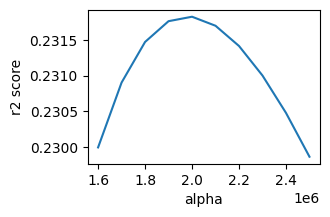

The best alpha is 2000000


R2 score for layer2 in function of the parameter alpha : 


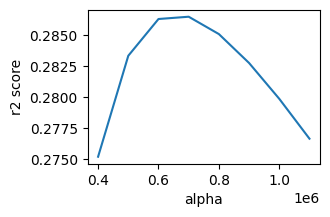

The best alpha is 700000


R2 score for layer3 in function of the parameter alpha : 


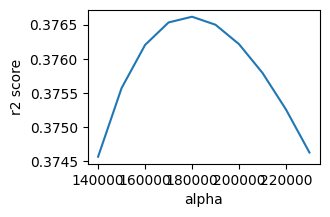

The best alpha is 180000


R2 score for layer4 in function of the parameter alpha : 


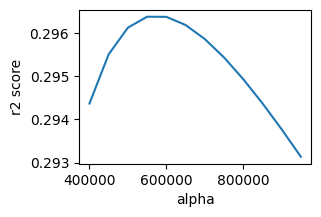

The best alpha is 550000


R2 score for avgpool in function of the parameter alpha : 


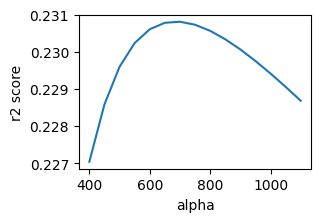

The best alpha is 700


In [33]:
# Use the PCs of each layer to predict the neural activity using linear regression models
models = {}
best_alphas = {}
alphas = {'conv1' : [11000000, 11500000, 12000000, 12500000, 13000000, 13500000, 14000000,14500000, 15000000,15500000, 16000000], 
          #'layer1' : [750000, 800000, 850000, 900000, 950000, 1000000], 
          'layer1' : [1600000, 1700000, 1800000, 1900000, 2000000, 2100000, 2200000, 2300000, 2400000, 2500000 ], 
          #'layer2' : [300000, 310000, 320000, 330000, 340000, 350000, 360000, 370000, 380000, 390000, 400000], 
          'layer2' : [400000, 500000, 600000, 700000, 800000, 900000, 1000000, 1100000], 
          #'layer3' : [100000, 105000, 110000, 115000, 120000, 125000, 130000, 135000, 140000], 
          'layer3' : [140000, 150000, 160000, 170000, 180000, 190000, 200000, 210000, 220000, 230000], 
          #'layer4' : [80000, 85000, 90000, 95000, 100000, 105000, 110000], 
          'layer4' : [400000, 450000, 500000, 550000, 600000, 650000, 700000, 750000, 800000, 850000, 900000, 950000], 
          #'avgpool' : [180, 190, 200, 210, 220, 230, 240, 250, 260, 270]
          'avgpool' : [400,450,500, 550,600, 650, 700, 750, 800,850, 900, 950, 1000, 1050, 1100,]}

for layer in layers : 
    with open(layer+'_train_W8.pkl', 'rb') as f:
        activations_train = pickle.load(f)  
    print('\n\nR2 score for', layer, 'in function of the parameter alpha : ')
    models[layer], best_alphas[layer] = RidgeCV(activations_train, spikes_train, alphas[layer])

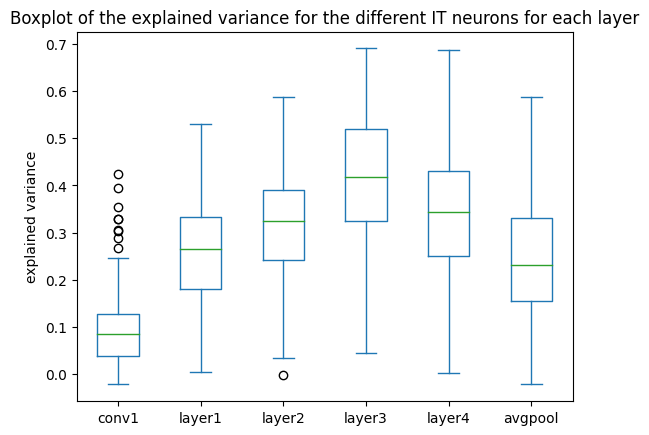

In [34]:
# Evaluate the models on the validation set
import pandas as pd
var = pd.DataFrame()
for layer in layers : 
    with open(layer+'_val_W8.pkl', 'rb') as f:
        activations_val = pickle.load(f)  
    var[layer] = explained_variance_score(spikes_val, models[layer].predict(activations_val), multioutput = 'raw_values')

var.plot(kind='box', title='Boxplot of the explained variance for the different IT neurons for each layer', ylabel='explained variance')
plt.show()

# Compare with layer3 activation of a randomly initialized resnet50

In [ ]:
# Intialize model
model_scratch = resnet50(weights = None)

# Extract the activations and compute the PCs
activations_train = model_scratch.extract_activations(stimulus_train, 'layer3')
pca = PCA(n_components=1000)
pca.fit(activations_train)    
with open('scratch_train.pkl','wb') as f:
    pickle.dump(pca.transform(activations_train), f)
with open('scratch_val.pkl','wb') as f:
    pickle.dump(pca.transform(model_scratch.extract_activations(stimulus_val, layer)), f)
    
# Predict the neural activity
alphas = [100000, 105000, 110000, 115000, 120000, 125000, 130000, 135000, 140000]
with open('scratch_train.pkl', 'rb') as f:
    activations_train = pickle.load(f)  
print('\n\nR2 score for the layer 3 of the scratch model in function of the parameter alpha : ')
ridge_scratch, best_alphas_scratch = RidgeCV(activations_train, spikes_train, alphas)

# Evaluate the model on the validation set
with open('scratch_val.pkl', 'rb') as f:
    activations_val = pickle.load(f)  
var['scratch layer 3'] = explained_variance_score(spikes_val, ridge_scratch.predict(activations_val), multioutput = 'raw_values')
    
var.plot(kind='box', title='Boxplot of the explained variance for the different IT neurons for each layer', ylabel='explained variance')
plt.show()